# Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from statsmodels.api import OLS
from sklearn.metrics import *
import statsmodels.api as sm
from sklearn import set_config
from xgboost import XGBRegressor
import numpy as np
set_config(display='diagram')
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

## Preparação Inicial

In [100]:
y_val = pd.read_csv('..//y_values.csv')

df = pd.read_parquet('..//raw_data//coin_id_formated.parquet')
df.head()

,id,symbol,name,asset_platform_id,hashing_algorithm,categories,description,country_origin,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count
0,01coin,zoc,zoc,nan,NeoScrypt,[Masternodes],,nan,NaN,NaN,NaN,2463,14.726,15.272,1.0,366.0,243.0
1,0-5x-long-algorand-token,algohalf,algohalf,ethereum,nan,[],0.5X Long Algorand Token (ALGOHALF) is an ERC2...,nan,NaN,NaN,NaN,12804,0.2,0.0,1.0,0.0,NaN
2,0-5x-long-altcoin-index-token,althalf,althalf,ethereum,nan,[],0.5X Long Altcoin Index Token (ALTHALF) is an ...,nan,NaN,NaN,NaN,13244,0.0,0.0,0.0,0.0,NaN
3,0-5x-long-ascendex-token-token,asdhalf,asdhalf,ethereum,nan,[],0.5X Long AscendEx Token (BTMX) Token (ASDHALF...,nan,NaN,NaN,NaN,13159,0.0,0.0,0.0,0.0,NaN
4,0-5x-long-bitcoin-cash-token,bchhalf,bchhalf,ethereum,nan,[],0.5X Long Bitcoin Cash Token (BCHHALF) is an E...,nan,NaN,NaN,NaN,12978,0.2,0.0,1.0,0.0,NaN


In [101]:
str_cols = ['id', 'symbol', 'name', 'asset_platform_id', 'hashing_algorithm','description','country_origin']
df[str_cols] = df[str_cols].astype(str)
float_cols = ['sentiment_votes_up_percentage', 'sentiment_votes_down_percentage','market_cap_rank', ]
df[float_cols] = df[float_cols].astype(float)
int_cols = ['coingecko_rank', 'coingecko_score','community_score', 'liquidity_score', 'twitter_followers',
       'telegram_channel_user_count']       
df[int_cols] = df[int_cols].astype(float)


### Analisando as categorias

In [102]:
df['categories'] = [
    x.tolist() if len(x.tolist()) != 0 else [None] for x in df['categories']
]
catHandler = pd.DataFrame(df['categories'].to_list(),
                          index=df['id']).values.ravel('K')

uniCats = pd.unique(catHandler)
uniCats = [x for x in uniCats if (x != None)]

df_cat_dummies = pd.DataFrame(index=df.id, columns=uniCats)

for coin, categories in df[['id', 'categories']].to_numpy():

    for categorie in categories:

        df_cat_dummies.loc[coin, categorie] = 1
        
df_cat_dummies.drop([None], axis=1, inplace=True)

In [103]:
df_cat_dummies = df_cat_dummies.fillna(0).astype(int)

In [104]:
ecossystens = []
cats = []
for x in df_cat_dummies.columns:
    if x.split()[-1] == 'Ecosystem':
        ecossystens.append(x)
    else:
        cats.append(x)

Fantom Ecosystem
Binance Smart Chain Ecosystem
Near Protocol Ecosystem
DaoMaker Ecosystem
Polygon Ecosystem
Avalanche Ecosystem
Polkadot Ecosystem
xDAI Ecosystem
Cosmos Ecosystem
Yearn Ecosystem
Solana Ecosystem
Terra Ecosystem
Arbitrum Ecosystem
Harmony Ecosystem
HECO Chain Ecosystem
Celo Ecosystem


<AxesSubplot:>

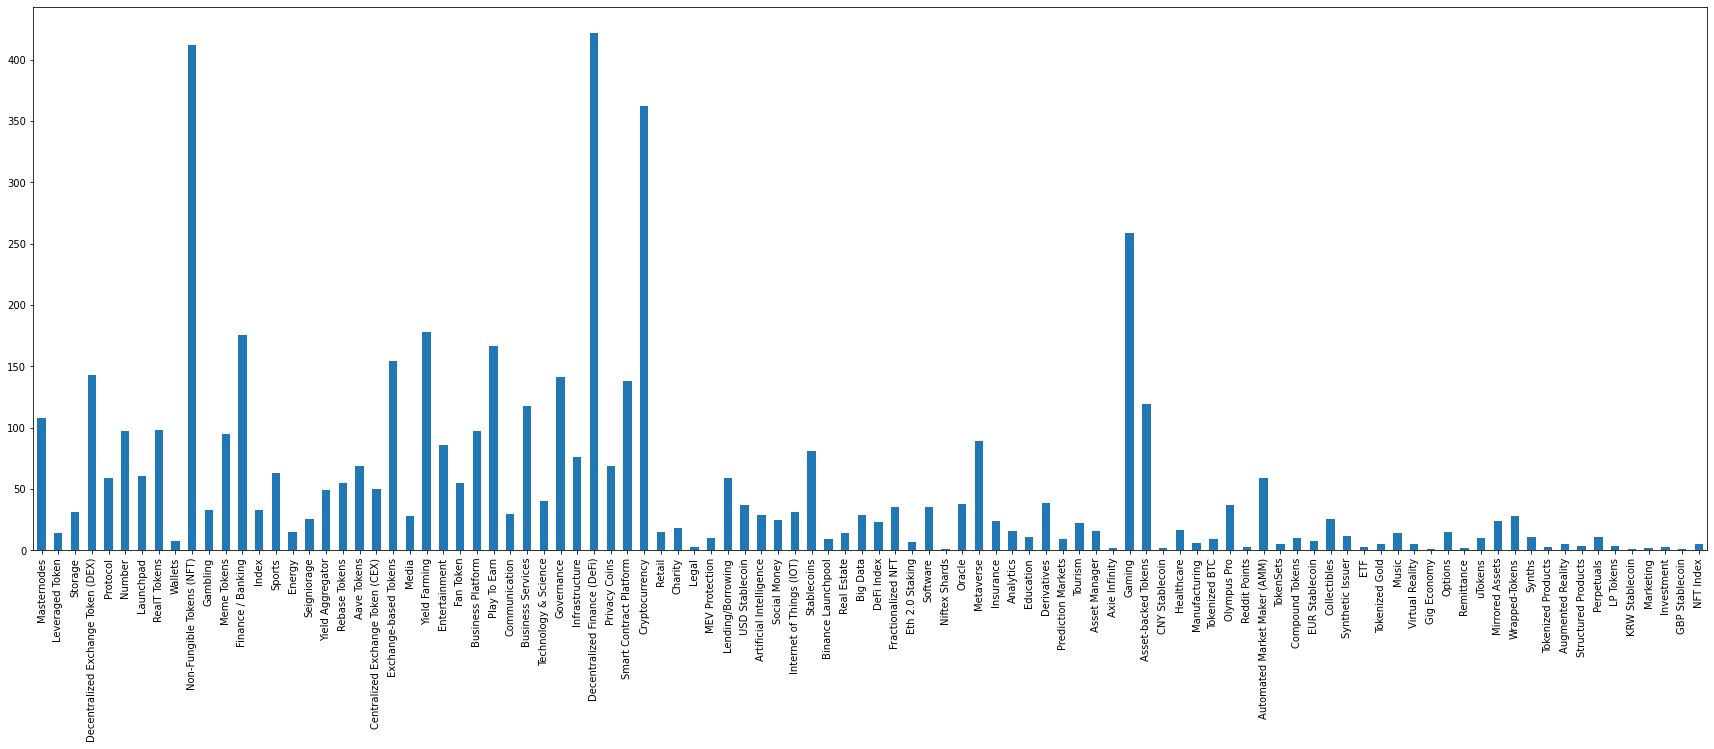

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
df_cat_dummies[cats].sum().plot(kind='bar')

<AxesSubplot:>

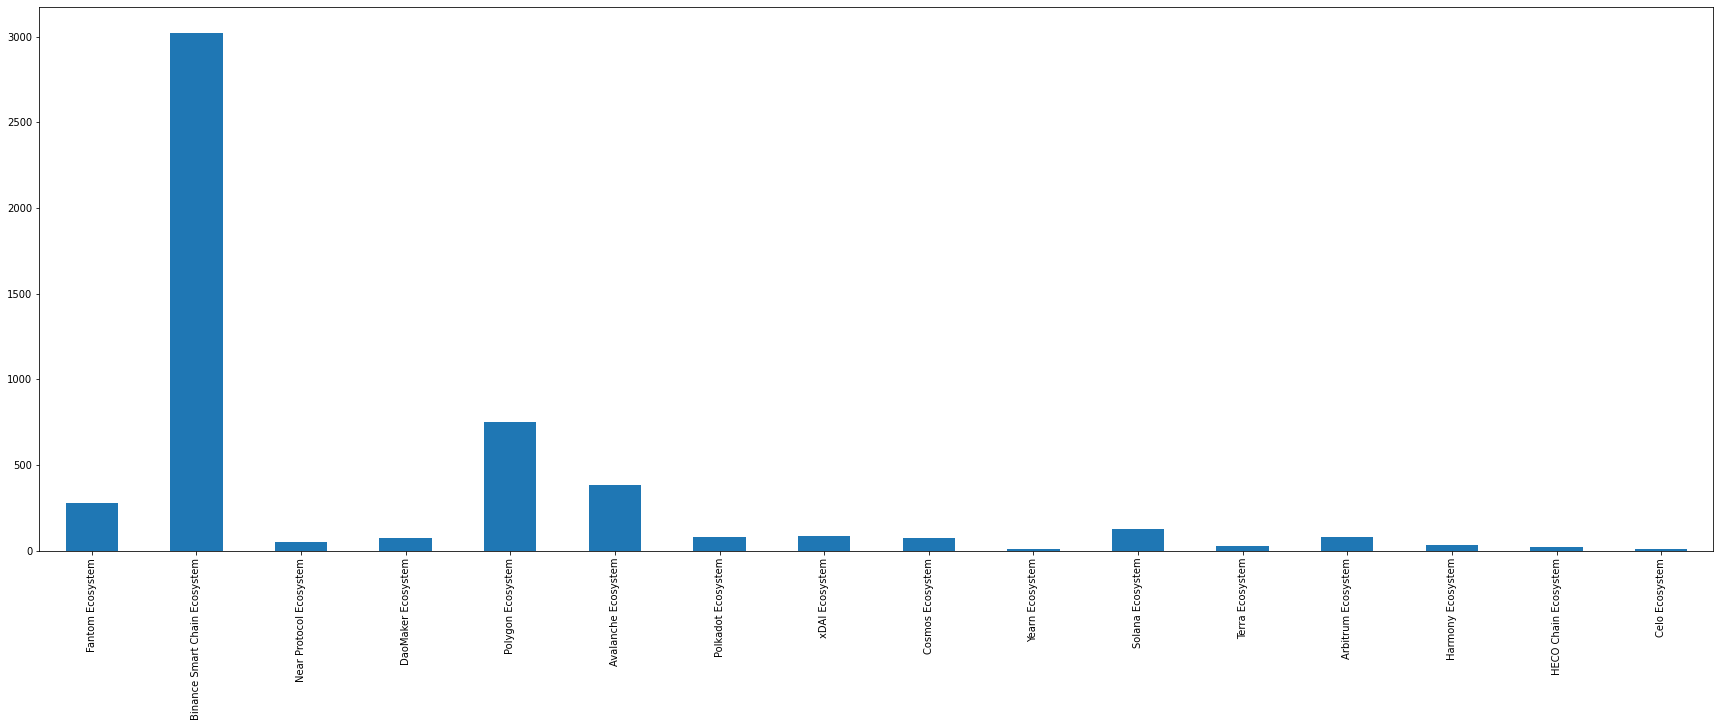

In [106]:
plt.figure(figsize=(30, 10))
df_cat_dummies[ecossystens].sum().plot(kind='bar')

In [9]:
df_cat_dummies.to_parquet("../raw_data/dummy_categories.parquet.gzip")

In [10]:
df_completo_categorias = df.merge(df_cat_dummies, left_on="id", right_index=True).drop("categories", axis=1)

In [11]:
df_completo_categorias.to_parquet("../raw_data/coin_id_with_categories.parquet.gzip")

In [12]:
y_val = y_val.replace([np.inf, -np.inf], np.nan).fillna(0)

In [13]:
df_completo_y = df_completo_categorias.merge(y_val, left_on='id', right_on='Unnamed: 0').drop("Unnamed: 0", axis=1)
df_completo_y.to_parquet("../coin_COMPLETO.parquet.gzip")

## Modelo de Regressao

In [2]:
df_completo_y = pd.read_parquet("../coin_COMPLETO.parquet.gzip")

###  Analise de Variaveis

In [15]:
df_completo_y.describe()


,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count,Masternodes,...,GBP Stablecoin,NFT Index,launch_price,0days_price,4days_price,16days_price,28days_price,90days_price,180days_price,360days_price
count,5388.000000,5388.000000,3793.000000,13110.000000,13241.000000,13241.000000,13241.000000,1.324100e+04,1.110500e+04,13241.000000,...,13241.000000,13241.000000,1.324100e+04,13241.000000,1.324100e+04,1.324100e+04,1.324100e+04,1.324100e+04,1.324100e+04,1.324100e+04
mean,72.636611,27.363400,1907.529133,6686.260564,7.963948,11.003455,6.053937,3.887708e+04,1.170131e+04,0.008156,...,0.000076,0.000378,3.155201e+09,0.741237,7.667472e+07,8.267461e+07,4.993490e+08,7.185643e+08,4.713738e+08,1.302232e+08
std,34.599060,34.599059,1127.557862,3910.932547,9.306983,9.828820,12.036557,2.530246e+05,2.973868e+04,0.089948,...,0.008690,0.019429,3.630488e+11,37.983683,8.822153e+09,9.355342e+09,3.981708e+10,6.854678e+10,4.145491e+10,1.498473e+10
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.717057e+00,-1.000000e+00
25%,50.000000,0.000000,950.000000,3289.250000,1.826000,6.373000,1.000000,4.840000e+02,9.690000e+02,0.000000,...,0.000000,0.000000,1.314000e-03,-0.040953,-3.259000e-01,-5.490360e-01,-6.842105e-01,-8.469926e-01,-7.451852e-01,-4.053076e-03
50%,87.500000,12.500000,1903.000000,6621.500000,4.013000,8.644000,1.000000,5.344000e+03,3.202000e+03,0.000000,...,0.000000,0.000000,6.995000e-02,0.000000,-7.950719e-02,-2.062044e-01,-3.263436e-01,-4.425299e-01,0.000000e+00,0.000000e+00
75%,100.000000,50.000000,2853.000000,10105.500000,12.032000,10.830000,3.453000,2.512800e+04,1.103700e+04,0.000000,...,0.000000,0.000000,1.070000e+00,0.000000,7.189542e-02,6.784137e-02,1.980198e-02,0.000000e+00,0.000000e+00,0.000000e+00
max,100.000000,100.000000,13284.000000,13510.000000,81.034000,85.250000,106.715000,1.186877e+07,1.432776e+06,1.000000,...,1.000000,1.000000,4.177586e+13,2683.365782,1.015161e+12,1.076402e+12,4.310528e+12,7.791093e+12,4.400987e+12,1.724286e+12


<AxesSubplot:ylabel='Frequency'>

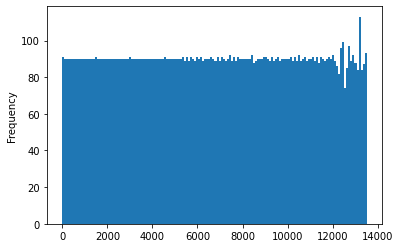

In [16]:
df[df['coingecko_rank'] != 0]['coingecko_rank'].plot(kind='hist', bins=150)


<AxesSubplot:ylabel='Frequency'>

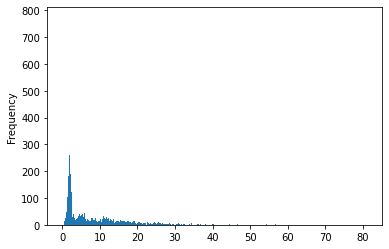

In [17]:
df[df['coingecko_score'] != 0]['coingecko_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

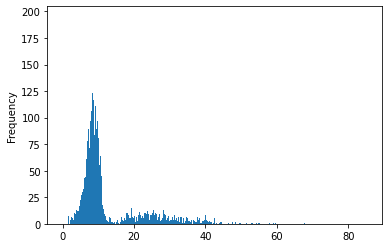

In [18]:
df[df['community_score'] != 0]['community_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

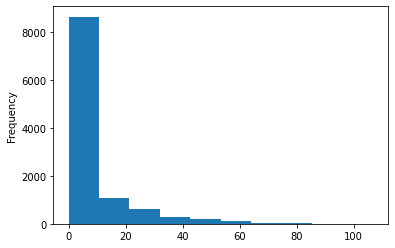

In [19]:
df[df['liquidity_score'] != 0]['liquidity_score'].plot(kind='hist')


<AxesSubplot:ylabel='Frequency'>

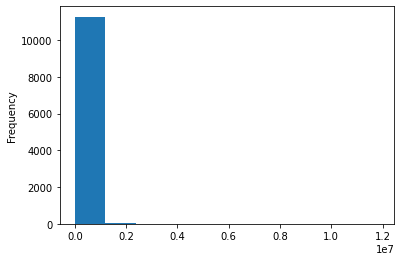

In [20]:
df[df['twitter_followers'] != 0]['twitter_followers'].plot(kind='hist')


### Build Pipeline

#### Modelo Individual

##### Foram removidos os coins que multiplicaram o capital mais de 5 vezes no periodo de 16 dias e as que moedas que tiveram o retorno = -0.999

In [85]:
df_aaaa = df_completo_y[(df_completo_y['16days_price']<5) & (df_completo_y['16days_price'] > -0.999) ].fillna(0).drop(['description', 'id', 'symbol', 'name','coingecko_rank','market_cap_rank'], axis=1)

In [92]:
final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include=["float64", 'int64'])),

    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object"))])

mod = XGBRegressor(eta=0.2, max_leaves=2)
pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('XGBRegressor', mod)], verbose=True)

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f22c44bfa90>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f22c44bfbe0>)])),
                ('XGBRegressor',
                 XGBRe...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None, max_leaves=2,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None, ...))],
         verbose=True)

In [93]:
X = df_aaaa[df_aaaa.columns[0:-9]]
y = df_aaaa['16days_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = pipe.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing XGBRegressor, total=  15.0s


In [94]:
a = list(zip(df_aaaa.columns[0:-9].to_list(), mod.feature_importances_.tolist()))

a

[('asset_platform_id', 0.005156488623470068),
 ('hashing_algorithm', 0.005063088610768318),
 ('country_origin', 0.005982184316962957),
 ('sentiment_votes_up_percentage', 0.0057008047588169575),
 ('sentiment_votes_down_percentage', 0.009064163081347942),
 ('coingecko_score', 0.008071130141615868),
 ('community_score', 0.005593643989413977),
 ('liquidity_score', 0.0033023033756762743),
 ('twitter_followers', 0.0),
 ('telegram_channel_user_count', 0.0035770200192928314),
 ('Masternodes', 0.008088712580502033),
 ('Leveraged Token', 0.002310218522325158),
 ('Storage', 0.0001711103686830029),
 ('Decentralized Exchange Token (DEX)', 0.008422266691923141),
 ('Protocol', 0.005732252262532711),
 ('Fantom Ecosystem', 0.0019905914086848497),
 ('Number', 0.006616638973355293),
 ('Launchpad', 0.0),
 ('RealT Tokens', 0.0),
 ('Binance Smart Chain Ecosystem', 0.007990705780684948),
 ('Wallets', 0.0017166408943012357),
 ('Near Protocol Ecosystem', 0.0057692378759384155),
 ('Non-Fungible Tokens (NFT)', 0

In [95]:
y_pred = model.predict(X_test)
print(round(mean_squared_error(y_test, y_pred)** 0.5,5))

0.78954


Text(0, 0.5, 'Actual Return')

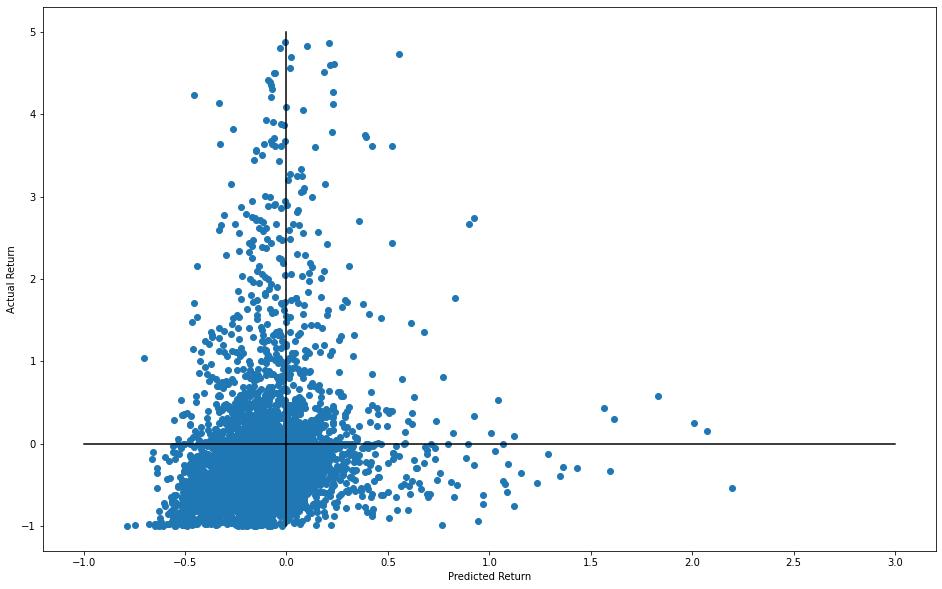

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.scatter(x=y_pred, y=y_test)

plt.plot([0,0], [-1, 5], color='black' )
plt.plot([-1, 3], [0,0], color='black')

plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")

#### Auto ML

In [28]:
import autosklearn.regression

final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include=["float64", 'int64'])),

    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object"))])

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=43200,
    per_run_time_limit=3000,
    memory_limit=20000
)
pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('linear_regression', automl)], verbose=True)

pipe




Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2efea819a0>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2f40d6a8b0>)])),
                ('linear_regression',
                 AutoSklearnRegressor(memory_limit=20000,
                                      per_run_time_limit=3000,
                                      time_left_for_this_task=43200))],
         verbose=True)

In [29]:
model = pipe.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s


/home/lchaves/.pyenv/versions/3.8.12/envs/web3/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/lchaves/.pyenv/versions/3.8.12/envs/web3/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[WARNING] [2022-05-05 17:27:12,203:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1


Error: Canceled future for execute_request message before replies were done

In [ ]:
print(automl.leaderboard())


          rank  ensemble_weight           type      cost   duration
model_id                                                           
126          1              1.0  decision_tree  1.000932  68.940697


In [ ]:
print(automl.show_models())

{126: {'model_id': 126, 'rank': 1, 'cost': 1.0009315338154925, 'ensemble_weight': 1.0, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f4753739f70>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f475382ca60>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f4756f19af0>, 'sklearn_regressor': DecisionTreeRegressor(criterion='mae', max_depth=238, min_samples_leaf=9,
                      min_samples_split=16, random_state=1)}}


In [ ]:
from sklearn.tree import DecisionTreeRegressor